# Leukemia Classification and Grading (Complete Pipeline)

This notebook orchestrates the entire pipeline for the Leukemia Classification and Grading project:
1.  **Setup**: Imports libraries and configures paths.
2.  **Data Preparation**: Preprocesses and splits the data into training, validation, and test sets.
3.  **Model Training**: Trains both a baseline and a multi-task model.
4.  **Prediction**: Uses the trained multi-task model to classify a new, single image.

## 1. Setup: Imports and Configuration

In [1]:
import os
import logging
import random
import shutil
import glob
from pathlib import Path

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

### Configuration

In [2]:
PROJECT_ROOT = Path('/Users/adarshainamdar/Documents/Major_Project')
DATA_DIR_RAW = PROJECT_ROOT / 'data/raw'

OUTPUTS_DIR = PROJECT_ROOT / 'outputs'
PROCESSED_DATA_DIR = PROJECT_ROOT / 'data/processed_data'
PROCESSED_DIR = PROCESSED_DATA_DIR / 'processed'
TRAIN_DIR = PROCESSED_DATA_DIR / 'train'
VAL_DIR = PROCESSED_DATA_DIR / 'val'
TEST_DIR = PROCESSED_DATA_DIR / 'test'
MODEL_DIR = OUTPUTS_DIR / 'models'
LOG_DIR = OUTPUTS_DIR / 'logs'

IMAGE_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
CLASSES = ['ALL', 'AML', 'CLL', 'CML']
GRADES = ['Chronic', 'Accelerated', 'Blast']

### Training Parameters

In [3]:
NUM_EPOCHS = 50
SKIP_DATA_PREP = False

## 2. Helper Functions and Classes

In [4]:
def setup_logging():
    """Configures the logging for the entire script."""
    LOG_DIR.mkdir(parents=True, exist_ok=True)
    LOG_FILE = LOG_DIR / 'training_notebook.log'
    
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
        
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(LOG_FILE, mode='w'),
            logging.StreamHandler()
        ]
    )
    logging.info(f"Logging setup complete. Log file: {LOG_FILE.resolve()}")

In [5]:
def prepare_data():
    """Checks for local data, then preprocesses and splits it."""
    if not DATA_DIR_RAW.exists():
        logging.error(f"Local data directory not found at '{DATA_DIR_RAW.resolve()}'.")
        return False
    else:
        logging.info(f"Found local data at '{DATA_DIR_RAW.resolve()}'.")

    logging.info("Starting image preprocessing (resizing to %dx%d)...", IMAGE_SIZE, IMAGE_SIZE)
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff']

    for cls in CLASSES:
        in_dir = DATA_DIR_RAW / cls
        out_dir = PROCESSED_DIR / cls
        out_dir.mkdir(parents=True, exist_ok=True)
        
        image_paths = []
        for ext in image_extensions:
            image_paths.extend(glob.glob(str(in_dir / '**' / ext), recursive=True))
            image_paths.extend(glob.glob(str(in_dir / '**' / ext.upper()), recursive=True))

        if not image_paths:
            logging.warning(f"No images found for class '{cls}' in directory '{in_dir}'. Skipping this class.")
            continue

        for fp in tqdm(image_paths, desc=f"Processing {cls}"):
            img = cv2.imread(fp)
            if img is not None:
                img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
                unique_name = f"{Path(fp).parent.name}_{Path(fp).name}"
                cv2.imwrite(str(out_dir / unique_name), img_resized)

    logging.info("Image preprocessing complete.")

    logging.info("Splitting data into train, validation, and test sets.")
    random.seed(42)
    for cls in CLASSES:
        files = list((PROCESSED_DIR / cls).glob('*.*'))
        if not files:
            continue
        random.shuffle(files)
        n = len(files)
        n_train, n_val = int(0.7 * n), int(0.15 * n)
        train_files, val_files, test_files = files[:n_train], files[n_train:n_train + n_val], files[n_train + n_val:]

        for d, fileset in [("train", train_files), ("val", val_files), ("test", test_files)]:
            dest_dir = PROCESSED_DATA_DIR / d / cls
            dest_dir.mkdir(parents=True, exist_ok=True)
            for f in fileset:
                shutil.copy2(f, dest_dir / f.name)
    logging.info("Data splitting complete.")

    total_files_in_train = sum([len(files) for r, d, files in os.walk(str(TRAIN_DIR))])
    if total_files_in_train == 0:
        logging.error("Data preparation step ran, but the training directory is empty.")
        return False
    
    return True

In [6]:
class MultiTaskModel(nn.Module):
    """A ResNet18 model with two separate heads for classification and grading."""
    def __init__(self, n_types, n_grades):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        d_model = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.head_type = nn.Linear(d_model, n_types)
        self.head_grade = nn.Linear(d_model, n_grades)

    def forward(self, x):
        features = self.backbone(x)
        return self.head_type(features), self.head_grade(features)

class MultiTaskDataset(datasets.ImageFolder):
    """Custom dataset to return type and (simulated) grade labels."""
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)
        self.grade_map = {cls: i % len(GRADES) for i, cls in enumerate(self.classes)}

    def __getitem__(self, index):
        path, type_label = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        
        class_name = self.classes[type_label]
        grade_label = self.grade_map[class_name]
        
        return sample, type_label, grade_label

In [7]:
def train_baseline_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs):
    logging.info("--- Starting Baseline Model Training ---")
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.item() / len(val_loader.dataset)
        logging.info(f"Epoch {epoch+1}/{num_epochs} | Validation Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), MODEL_DIR / 'baseline_cls.pt')
            logging.info(f"New best baseline model saved with acc: {best_val_acc:.4f}")

In [8]:
def train_multitask_model(model, criteria, optimizer, train_loader, val_loader, device, num_epochs):
    logging.info("--- Starting Multi-Task Model Training ---")
    model.to(device)
    best_val_acc = 0.0
    type_criterion, grade_criterion = criteria

    for epoch in range(num_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for inputs, type_labels, grade_labels in loop:
            inputs, type_labels, grade_labels = inputs.to(device), type_labels.to(device), grade_labels.to(device)
            optimizer.zero_grad()
            type_logits, grade_logits = model(inputs)
            loss = type_criterion(type_logits, type_labels) + 0.5 * grade_criterion(grade_logits, grade_labels)
            loss.backward()
            optimizer.step()

        model.eval()
        type_corrects = 0
        with torch.no_grad():
            for inputs, type_labels, _ in val_loader:
                inputs, type_labels = inputs.to(device), type_labels.to(device)
                type_logits, _ = model(inputs)
                _, type_preds = torch.max(type_logits, 1)
                type_corrects += torch.sum(type_preds == type_labels.data)
        
        val_type_acc = type_corrects.item() / len(val_loader.dataset)
        logging.info(f"Epoch {epoch+1}/{num_epochs} | Validation Type Acc: {val_type_acc:.4f}")

        if val_type_acc > best_val_acc:
            best_val_acc = val_type_acc
            torch.save(model.state_dict(), MODEL_DIR / 'multitask_model.pt')
            logging.info(f"New best multi-task model saved with acc: {best_val_acc:.4f}")

In [9]:
def evaluate_model(model, loader, device, class_names):
    logging.info("--- Evaluating Model on Test Set ---")
    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    report = classification_report(y_true, y_pred, target_names=class_names)
    logging.info("Classification Report:\n%s", report)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## 3. Main Pipeline Execution

This block runs the entire data preparation and training pipeline.

2025-09-11 15:50:13,857 - INFO - Logging setup complete. Log file: /Users/adarshainamdar/Documents/Major_Project/outputs/logs/training_notebook.log
2025-09-11 15:50:13,859 - INFO - Found local data at '/Users/adarshainamdar/Documents/Major_Project/data/raw'.
2025-09-11 15:50:13,860 - INFO - Starting image preprocessing (resizing to 224x224)...


Processing ALL:   0%|          | 0/320 [00:00<?, ?it/s]

Processing AML:   0%|          | 0/320 [00:00<?, ?it/s]

Processing CLL:   0%|          | 0/320 [00:00<?, ?it/s]

Processing CML:   0%|          | 0/320 [00:00<?, ?it/s]

2025-09-11 15:50:15,791 - INFO - Image preprocessing complete.
2025-09-11 15:50:15,792 - INFO - Splitting data into train, validation, and test sets.
2025-09-11 15:50:16,275 - INFO - Data splitting complete.
2025-09-11 15:50:16,292 - INFO - Using device: mps
2025-09-11 15:50:16,293 - INFO - 
=== BASELINE MODEL PIPELINE ===
2025-09-11 15:50:16,468 - INFO - --- Starting Baseline Model Training ---


Epoch 1/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:50:21,389 - INFO - Epoch 1/50 | Validation Acc: 0.5781
2025-09-11 15:50:21,457 - INFO - New best baseline model saved with acc: 0.5781


Epoch 2/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:50:25,887 - INFO - Epoch 2/50 | Validation Acc: 0.6198
2025-09-11 15:50:25,960 - INFO - New best baseline model saved with acc: 0.6198


Epoch 3/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:50:30,471 - INFO - Epoch 3/50 | Validation Acc: 0.6250
2025-09-11 15:50:30,544 - INFO - New best baseline model saved with acc: 0.6250


Epoch 4/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:50:35,027 - INFO - Epoch 4/50 | Validation Acc: 0.5781


Epoch 5/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:50:39,498 - INFO - Epoch 5/50 | Validation Acc: 0.6250


Epoch 6/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:50:44,120 - INFO - Epoch 6/50 | Validation Acc: 0.6094


Epoch 7/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:50:48,630 - INFO - Epoch 7/50 | Validation Acc: 0.6667
2025-09-11 15:50:48,703 - INFO - New best baseline model saved with acc: 0.6667


Epoch 8/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:50:53,152 - INFO - Epoch 8/50 | Validation Acc: 0.7604
2025-09-11 15:50:53,239 - INFO - New best baseline model saved with acc: 0.7604


Epoch 9/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:50:57,702 - INFO - Epoch 9/50 | Validation Acc: 0.6510


Epoch 10/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:02,151 - INFO - Epoch 10/50 | Validation Acc: 0.7396


Epoch 11/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:06,586 - INFO - Epoch 11/50 | Validation Acc: 0.7760
2025-09-11 15:51:06,655 - INFO - New best baseline model saved with acc: 0.7760


Epoch 12/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:11,180 - INFO - Epoch 12/50 | Validation Acc: 0.7396


Epoch 13/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:15,610 - INFO - Epoch 13/50 | Validation Acc: 0.6615


Epoch 14/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:20,056 - INFO - Epoch 14/50 | Validation Acc: 0.7812
2025-09-11 15:51:20,132 - INFO - New best baseline model saved with acc: 0.7812


Epoch 15/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:24,616 - INFO - Epoch 15/50 | Validation Acc: 0.7656


Epoch 16/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:29,025 - INFO - Epoch 16/50 | Validation Acc: 0.7344


Epoch 17/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:33,419 - INFO - Epoch 17/50 | Validation Acc: 0.6562


Epoch 18/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:37,830 - INFO - Epoch 18/50 | Validation Acc: 0.6927


Epoch 19/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:42,249 - INFO - Epoch 19/50 | Validation Acc: 0.8281
2025-09-11 15:51:42,320 - INFO - New best baseline model saved with acc: 0.8281


Epoch 20/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:46,744 - INFO - Epoch 20/50 | Validation Acc: 0.7917


Epoch 21/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:51,161 - INFO - Epoch 21/50 | Validation Acc: 0.6667


Epoch 22/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:51:55,566 - INFO - Epoch 22/50 | Validation Acc: 0.8438
2025-09-11 15:51:55,631 - INFO - New best baseline model saved with acc: 0.8438


Epoch 23/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:00,024 - INFO - Epoch 23/50 | Validation Acc: 0.8021


Epoch 24/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:04,480 - INFO - Epoch 24/50 | Validation Acc: 0.7812


Epoch 25/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:08,883 - INFO - Epoch 25/50 | Validation Acc: 0.7969


Epoch 26/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:13,396 - INFO - Epoch 26/50 | Validation Acc: 0.7812


Epoch 27/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:17,810 - INFO - Epoch 27/50 | Validation Acc: 0.8802
2025-09-11 15:52:17,876 - INFO - New best baseline model saved with acc: 0.8802


Epoch 28/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:22,284 - INFO - Epoch 28/50 | Validation Acc: 0.7969


Epoch 29/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:26,698 - INFO - Epoch 29/50 | Validation Acc: 0.8698


Epoch 30/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:31,302 - INFO - Epoch 30/50 | Validation Acc: 0.8854
2025-09-11 15:52:31,378 - INFO - New best baseline model saved with acc: 0.8854


Epoch 31/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:35,803 - INFO - Epoch 31/50 | Validation Acc: 0.7708


Epoch 32/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:40,221 - INFO - Epoch 32/50 | Validation Acc: 0.8333


Epoch 33/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:44,636 - INFO - Epoch 33/50 | Validation Acc: 0.8229


Epoch 34/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:49,146 - INFO - Epoch 34/50 | Validation Acc: 0.8698


Epoch 35/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:53,637 - INFO - Epoch 35/50 | Validation Acc: 0.8906
2025-09-11 15:52:53,709 - INFO - New best baseline model saved with acc: 0.8906


Epoch 36/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:52:58,179 - INFO - Epoch 36/50 | Validation Acc: 0.8438


Epoch 37/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:02,636 - INFO - Epoch 37/50 | Validation Acc: 0.8490


Epoch 38/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:07,117 - INFO - Epoch 38/50 | Validation Acc: 0.8229


Epoch 39/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:11,552 - INFO - Epoch 39/50 | Validation Acc: 0.8906


Epoch 40/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:15,997 - INFO - Epoch 40/50 | Validation Acc: 0.8490


Epoch 41/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:20,415 - INFO - Epoch 41/50 | Validation Acc: 0.8385


Epoch 42/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:24,800 - INFO - Epoch 42/50 | Validation Acc: 0.8594


Epoch 43/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:29,189 - INFO - Epoch 43/50 | Validation Acc: 0.8906


Epoch 44/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:33,569 - INFO - Epoch 44/50 | Validation Acc: 0.8698


Epoch 45/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:38,073 - INFO - Epoch 45/50 | Validation Acc: 0.8802


Epoch 46/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:42,507 - INFO - Epoch 46/50 | Validation Acc: 0.8438


Epoch 47/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:46,913 - INFO - Epoch 47/50 | Validation Acc: 0.8906


Epoch 48/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:51,335 - INFO - Epoch 48/50 | Validation Acc: 0.8854


Epoch 49/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:53:55,765 - INFO - Epoch 49/50 | Validation Acc: 0.7292


Epoch 50/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:00,301 - INFO - Epoch 50/50 | Validation Acc: 0.8542
2025-09-11 15:54:00,303 - INFO - 
Loading best baseline model for final evaluation.
2025-09-11 15:54:00,349 - INFO - --- Evaluating Model on Test Set ---
2025-09-11 15:54:00,735 - INFO - Classification Report:
              precision    recall  f1-score   support

         ALL       0.92      1.00      0.96        48
         AML       0.88      0.92      0.90        48
         CLL       0.79      0.92      0.85        48
         CML       0.97      0.69      0.80        48

    accuracy                           0.88       192
   macro avg       0.89      0.88      0.88       192
weighted avg       0.89      0.88      0.88       192



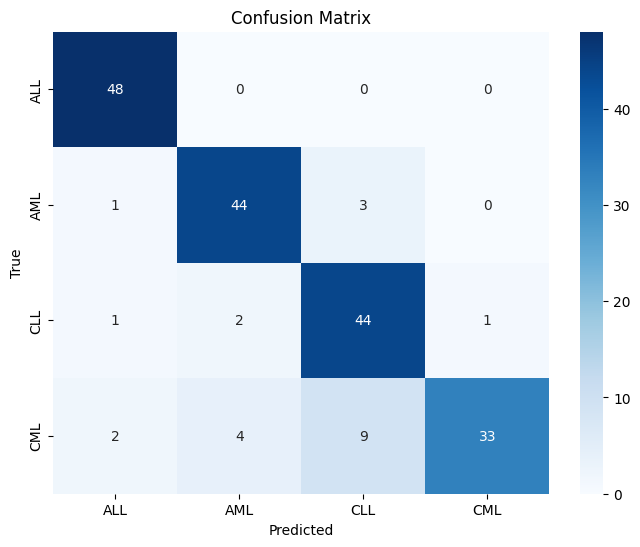

2025-09-11 15:54:00,801 - INFO - 
=== MULTI-TASK MODEL PIPELINE ===
2025-09-11 15:54:00,978 - INFO - --- Starting Multi-Task Model Training ---


Epoch 1/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:05,601 - INFO - Epoch 1/50 | Validation Type Acc: 0.3646
2025-09-11 15:54:05,692 - INFO - New best multi-task model saved with acc: 0.3646


Epoch 2/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:10,184 - INFO - Epoch 2/50 | Validation Type Acc: 0.6250
2025-09-11 15:54:10,253 - INFO - New best multi-task model saved with acc: 0.6250


Epoch 3/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:14,789 - INFO - Epoch 3/50 | Validation Type Acc: 0.6458
2025-09-11 15:54:14,862 - INFO - New best multi-task model saved with acc: 0.6458


Epoch 4/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:19,365 - INFO - Epoch 4/50 | Validation Type Acc: 0.5729


Epoch 5/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:23,920 - INFO - Epoch 5/50 | Validation Type Acc: 0.6042


Epoch 6/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:28,442 - INFO - Epoch 6/50 | Validation Type Acc: 0.6927
2025-09-11 15:54:28,512 - INFO - New best multi-task model saved with acc: 0.6927


Epoch 7/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:32,945 - INFO - Epoch 7/50 | Validation Type Acc: 0.6146


Epoch 8/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:37,437 - INFO - Epoch 8/50 | Validation Type Acc: 0.6927


Epoch 9/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:41,941 - INFO - Epoch 9/50 | Validation Type Acc: 0.7083
2025-09-11 15:54:42,039 - INFO - New best multi-task model saved with acc: 0.7083


Epoch 10/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:46,517 - INFO - Epoch 10/50 | Validation Type Acc: 0.6823


Epoch 11/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:50,960 - INFO - Epoch 11/50 | Validation Type Acc: 0.6823


Epoch 12/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:55,399 - INFO - Epoch 12/50 | Validation Type Acc: 0.6146


Epoch 13/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:54:59,848 - INFO - Epoch 13/50 | Validation Type Acc: 0.7708
2025-09-11 15:54:59,919 - INFO - New best multi-task model saved with acc: 0.7708


Epoch 14/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:04,398 - INFO - Epoch 14/50 | Validation Type Acc: 0.7396


Epoch 15/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:08,869 - INFO - Epoch 15/50 | Validation Type Acc: 0.7188


Epoch 16/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:13,303 - INFO - Epoch 16/50 | Validation Type Acc: 0.6823


Epoch 17/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:17,739 - INFO - Epoch 17/50 | Validation Type Acc: 0.7812
2025-09-11 15:55:17,811 - INFO - New best multi-task model saved with acc: 0.7812


Epoch 18/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:22,388 - INFO - Epoch 18/50 | Validation Type Acc: 0.7760


Epoch 19/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:26,840 - INFO - Epoch 19/50 | Validation Type Acc: 0.8125
2025-09-11 15:55:26,905 - INFO - New best multi-task model saved with acc: 0.8125


Epoch 20/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:31,357 - INFO - Epoch 20/50 | Validation Type Acc: 0.7604


Epoch 21/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:35,790 - INFO - Epoch 21/50 | Validation Type Acc: 0.8021


Epoch 22/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:40,294 - INFO - Epoch 22/50 | Validation Type Acc: 0.7448


Epoch 23/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:44,773 - INFO - Epoch 23/50 | Validation Type Acc: 0.7969


Epoch 24/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:49,295 - INFO - Epoch 24/50 | Validation Type Acc: 0.8125


Epoch 25/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:53,766 - INFO - Epoch 25/50 | Validation Type Acc: 0.7969


Epoch 26/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:55:58,237 - INFO - Epoch 26/50 | Validation Type Acc: 0.7500


Epoch 27/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:02,769 - INFO - Epoch 27/50 | Validation Type Acc: 0.8594
2025-09-11 15:56:02,840 - INFO - New best multi-task model saved with acc: 0.8594


Epoch 28/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:07,278 - INFO - Epoch 28/50 | Validation Type Acc: 0.7448


Epoch 29/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:11,713 - INFO - Epoch 29/50 | Validation Type Acc: 0.8281


Epoch 30/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:16,136 - INFO - Epoch 30/50 | Validation Type Acc: 0.7917


Epoch 31/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:20,558 - INFO - Epoch 31/50 | Validation Type Acc: 0.8646
2025-09-11 15:56:20,628 - INFO - New best multi-task model saved with acc: 0.8646


Epoch 32/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:25,027 - INFO - Epoch 32/50 | Validation Type Acc: 0.9010
2025-09-11 15:56:25,104 - INFO - New best multi-task model saved with acc: 0.9010


Epoch 33/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:29,521 - INFO - Epoch 33/50 | Validation Type Acc: 0.7708


Epoch 34/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:33,927 - INFO - Epoch 34/50 | Validation Type Acc: 0.7500


Epoch 35/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:38,493 - INFO - Epoch 35/50 | Validation Type Acc: 0.8646


Epoch 36/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:42,931 - INFO - Epoch 36/50 | Validation Type Acc: 0.7865


Epoch 37/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:47,339 - INFO - Epoch 37/50 | Validation Type Acc: 0.8438


Epoch 38/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:51,753 - INFO - Epoch 38/50 | Validation Type Acc: 0.7448


Epoch 39/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:56:56,169 - INFO - Epoch 39/50 | Validation Type Acc: 0.8802


Epoch 40/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:00,619 - INFO - Epoch 40/50 | Validation Type Acc: 0.8594


Epoch 41/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:05,137 - INFO - Epoch 41/50 | Validation Type Acc: 0.8542


Epoch 42/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:09,663 - INFO - Epoch 42/50 | Validation Type Acc: 0.8177


Epoch 43/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:14,095 - INFO - Epoch 43/50 | Validation Type Acc: 0.8438


Epoch 44/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:18,527 - INFO - Epoch 44/50 | Validation Type Acc: 0.8125


Epoch 45/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:23,009 - INFO - Epoch 45/50 | Validation Type Acc: 0.8906


Epoch 46/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:27,565 - INFO - Epoch 46/50 | Validation Type Acc: 0.8229


Epoch 47/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:32,120 - INFO - Epoch 47/50 | Validation Type Acc: 0.8958


Epoch 48/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:36,556 - INFO - Epoch 48/50 | Validation Type Acc: 0.7760


Epoch 49/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:40,969 - INFO - Epoch 49/50 | Validation Type Acc: 0.8125


Epoch 50/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-11 15:57:45,512 - INFO - Epoch 50/50 | Validation Type Acc: 0.8073
2025-09-11 15:57:45,513 - INFO - 
Pipeline finished successfully.


In [10]:
setup_logging()

MODEL_DIR.mkdir(parents=True, exist_ok=True)

if not SKIP_DATA_PREP:
    data_prep_success = prepare_data()
    if not data_prep_success:
        raise RuntimeError("Data preparation failed. Check logs for details.")
else:
    logging.info("Skipping data preparation as requested.")

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
logging.info(f"Using device: {device}")

tfm_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
tfm_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

logging.info("\n=== BASELINE MODEL PIPELINE ===")
train_ds = datasets.ImageFolder(str(TRAIN_DIR), tfm_train)
val_ds = datasets.ImageFolder(str(VAL_DIR), tfm_eval)
test_ds = datasets.ImageFolder(str(TEST_DIR), tfm_eval)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

baseline_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, len(CLASSES))

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseline_model.parameters(), lr=LEARNING_RATE)

train_baseline_model(baseline_model, criterion, optimizer, train_dl, val_dl, device, NUM_EPOCHS)

logging.info("\nLoading best baseline model for final evaluation.")
baseline_model.load_state_dict(torch.load(MODEL_DIR / 'baseline_cls.pt'))
evaluate_model(baseline_model, test_dl, device, class_names=CLASSES)

logging.info("\n=== MULTI-TASK MODEL PIPELINE ===")
mt_train_ds = MultiTaskDataset(str(TRAIN_DIR), tfm_train)
mt_val_ds = MultiTaskDataset(str(VAL_DIR), tfm_eval)

mt_train_dl = DataLoader(mt_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
mt_val_dl = DataLoader(mt_val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

multitask_model = MultiTaskModel(n_types=len(CLASSES), n_grades=len(GRADES))

mt_criteria = (nn.CrossEntropyLoss(), nn.CrossEntropyLoss())
mt_optimizer = optim.AdamW(multitask_model.parameters(), lr=LEARNING_RATE)

train_multitask_model(multitask_model, mt_criteria, mt_optimizer, mt_train_dl, mt_val_dl, device, NUM_EPOCHS)

logging.info("\nPipeline finished successfully.")

## 4. Making a Prediction on a New Image

After training, you can use this section to load your best `multitask_model` and make a prediction on any single image file.

In [11]:
def predict_leukemia(model_path, image_path, device):
    """
    Loads the trained multi-task model and predicts the class and grade
    for a single input image.
    """
    # 1. Initialize the model architecture (the class MultiTaskModel must be defined)
    model = MultiTaskModel(n_types=len(CLASSES), n_grades=len(GRADES))
    
    # 2. Load the saved weights
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.to(device)
    
    # 3. Set the model to evaluation mode
    model.eval()

    # 4. Define the same image transformations as used for validation/testing
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 5. Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    # 6. Make a prediction
    with torch.no_grad():
        type_logits, grade_logits = model(image_tensor)
        type_pred_idx = torch.argmax(type_logits, dim=1).item()
        grade_pred_idx = torch.argmax(grade_logits, dim=1).item()

    # 7. Map the index back to the class and grade names
    predicted_class = CLASSES[type_pred_idx]
    predicted_grade = GRADES[grade_pred_idx]
    
    return (predicted_class, predicted_grade)

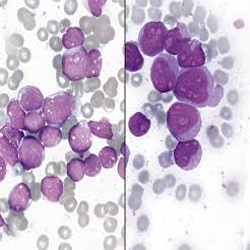

🚀 Prediction Complete!
   - Predicted Class: AML
   - Predicted Grade: Accelerated


In [13]:
# --- SETTINGS FOR PREDICTION ---
SAVED_MODEL_PATH = MODEL_DIR / 'multitask_model.pt'

# ✅ IMPORTANT: Change this to the path of the image you want to classify!
YOUR_IMAGE_PATH = input('Enter the path of image:')#'/Users/adarshainamdar/Documents/Major_Project/Unknown-2.jpeg' 

# --- RUN PREDICTION ---
try:
    # Display the image
    display(Image.open(YOUR_IMAGE_PATH).resize((250, 250)))
    
    predicted_class, predicted_grade = predict_leukemia(
        model_path=SAVED_MODEL_PATH,
        image_path=YOUR_IMAGE_PATH,
        device=device # This 'device' variable was defined in the training cell
    )

    print("🚀 Prediction Complete!")
    print(f"   - Predicted Class: {predicted_class}")
    print(f"   - Predicted Grade: {predicted_grade}")

except FileNotFoundError:
    print(f"Error: The image file was not found at '{YOUR_IMAGE_PATH}'")
    print("Please make sure the path is correct and re-run the cell.")
except Exception as e:
    print(f"An error occurred: {e}")